In [ ]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import urllib
import pickle
import cv2
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import random 
import re
import math
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image
from glob import glob


sns.set_style('white')
torch.cuda.empty_cache()

# GradCamがちゃんと動くか、愛犬で確かめる。

In [ ]:
#　Grad_camを実装(方法１)

drive_dir = 'drive/MyDrive/Lung_Nodule_2/Grad_CAM/'

# ImageNet のラベルをダウンロード, 
labels = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

In [ ]:
model = models.vgg19(pretrained=True)

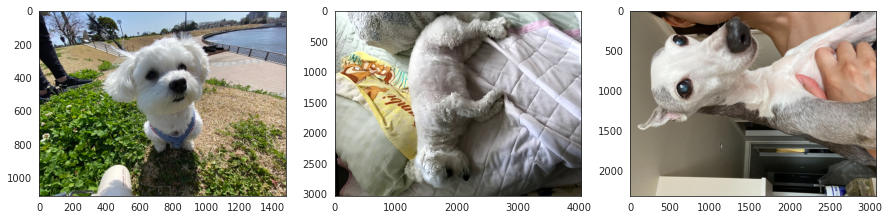

In [ ]:
test_image1 = Image.open(drive_dir + 'IMG_0764.JPG')
test_image2 = Image.open(drive_dir + 'latte.JPG')
test_image3 = Image.open(drive_dir + 'ANNA.JPG')

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(test_image1)
ax[1].imshow(test_image2)
ax[2].imshow(test_image3)

In [ ]:
transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.4305, 0.4305, 0.4305],
                                std=[0.3505, 0.3505, 0.3505])
])

test_image1_tensor = transform(test_image1)
test_image2_tensor = transform(test_image2)
test_image3_tensor = transform(test_image3)

print(test_image1_tensor.size())

# バッチサイズの次元を追加。
test_image1_tensor = test_image1_tensor.unsqueeze(0)
test_image2_tensor = test_image2_tensor.unsqueeze(0)
test_image3_tensor = test_image3_tensor.unsqueeze(0)
print(test_image1_tensor.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
model = model.eval()
with torch.no_grad():
  predict1_index = model(test_image1_tensor).max(1)[1]
  predict2_index = model(test_image2_tensor).max(1)[1]
  predict3_index = model(test_image3_tensor).max(1)[1]
  print('検証画像1の予測結果', labels[int(predict1_index)])
  print('検証画像2の予測結果', labels[int(predict2_index)])
  print('検証画像3の予測結果', labels[int(predict3_index)])



検証画像1の予測結果 Maltese dog, Maltese terrier, Maltese
検証画像2の予測結果 quilt, comforter, comfort, puff
検証画像3の予測結果 Chihuahua


In [ ]:
# modelをバラしている.モデルの構造を知っている必要がある。
features = model.features.eval()
avgpool = model.avgpool.eval()
classifier = model.classifier.eval()

In [ ]:
#　特徴マップを抽出する。
feature = features(test_image1_tensor)
print('特徴マップサイズ', feature.size())

feature = feature.clone().detach().requires_grad_(True)

# 特徴マップをVGG19の残りの全結合層に通して、予測結果を知る。　
pooled = avgpool(feature)
y_pred = classifier(pooled.view(-1, 512*7*7))
pred_index = torch.argmax(y_pred)

# 予測結果に対して、逆誤差伝搬　
y_pred[0][pred_index].backward()

特徴マップサイズ torch.Size([1, 512, 7, 7])


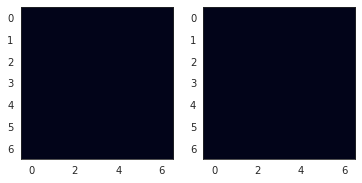

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(feature[0, 10, :, :].detach().numpy())
ax[1].imshow(pooled[0, 10, :, :].detach().numpy())

In [ ]:
# 特徴マップの勾配(feature.grad)のGlobal Average Poolingを計算する
# 7 * 7のそれぞれの特徴マップを１本のベクトルに変換。
feature_vec = feature.grad.view(512, 7*7)
print(feature_vec.shape)

# 512本のベクトルのそれぞれの平均を求める。
alpha = torch.mean(feature_vec, axis=1)
print(alpha.shape)

# batchsizeのいらない次元を削除
feature = feature.squeeze(0)

# 論文中のLを計算
L = F.relu(torch.sum(feature*alpha.view(-1, 1, 1), axis=0))
L = L.detach().numpy()
print(L.shape)

torch.Size([512, 49])
torch.Size([512])
(7, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


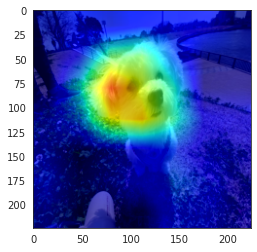

In [ ]:
# 0~1へ正規化
L_min = np.min(L)
L_max = np.max(L - L_min)
L = L - L_min / L_max

# 元の画像サイズにあわせる
L = cv2.resize(L, (224, 224))

def toHeatmap(x):
  x = (x*255).reshape(-1)
  # カラーマップを取得している。
  cm = plt.get_cmap('jet')
  x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
  return x.reshape(224, 224, 3)

img2 = toHeatmap(L)
img1 = test_image1_tensor.squeeze(0).permute(1, 2, 0)

alpha = 0.2
grad_cam_image = img1 * alpha + img2 * (1-alpha)
plt.imshow(grad_cam_image)

In [ ]:
# 実装方法２実装方法２

# moduleのforward関数がよばれるときに、一緒に実行したい内容を記載する。
def forward_hook(module, inputs, outputs):
  '''
  module: 登録先のネットワーク
  inputs: moduleのforward関数のインプットとなったデータ
  outputs: moduleのforward関数のアウトプット
  '''
  global feature
  # 複数のinputsに対応できるように、inputsはtupleでラップされている。
  # 今回はinputsは1つなので、[0]を指定。
  # hook関数の登録先であるmoduleは、今回は特徴マップを計算する層(model.feature)を想定しているので、
  # model.featuresの計算結果である、outputsをそのまま取得できるようにする。
  feature = outputs[0] # feature.size() = (1 * 512 * 7 * 7)


# moduleのbackward関数がよばれる時に、一緒に実行したい内容を記載する。
def backward_hook(module, grad_inputs, grad_outputs):
  '''
  module: 登録先のネットワーク
  grad_inputs: moduleのbackward関数のインプットとなったデータ
  grad_outputs: moduleのbackward関数のアウトプット
  '''
  global feature_grad
  # hook関数の登録先であるmoduleは、forward_hookと同様にmodel.featuresを想定しているので、
  # 特徴マップの勾配が欲しいので、model.featuresの勾配結果に相当するgrad_outputsをそのまま取得する。
  feature_grad = grad_outputs[0] # feature_grad.size() = (1 * 512 * 7 * 7)


# 畳み込み層に、hook関数を登録する。
# これによってVGG19にデータが流れる際、順伝搬の畳み込み処理のところで上記の forward_hookが呼び出される。
# そしてglobal変数のfeatureに特徴マップが格納される。
# 同様に逆伝搬時にglobal変数のfeature_gradに特徴マップの勾配が格納される。
model.features.register_forward_hook(forward_hook)
model.features.register_backward_hook(backward_hook)

# このタイミングで,forward_hookが呼び出されている。
y_pred = model(test_image2_tensor)
pred_index = torch.argmax(y_pred)

# y_pred[0]は、１枚の画像しか予測していないので0を指定。
# 予測結果に対して、逆誤差伝搬。
# このタイミングで,backward_hookが呼び出されている。
y_pred[0][pred_index].backward()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
# ここからは方法１と同じ。
feature_grad = feature_grad.squeeze()
feature_vec = feature_grad.view(512, 7*7)

alpha = torch.mean(feature_vec, axis=1)

L = F.relu(torch.sum(feature * alpha.view(-1, 1, 1), axis=0))
L = L.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


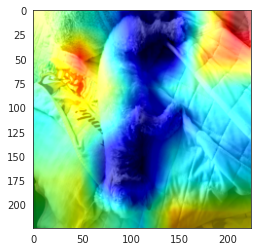

In [ ]:
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min) / L_max

L = cv2.resize(L, (224, 224))

def heat(x):
  # reshape(-1)でフラットにしている。for文で1pixelごと取得するため。
  x = x * 255
  x = x.reshape(-1)
  cm = plt.get_cmap('jet')
  x = np.array([cm(int(np.round(i)))[:3] for i in x])
  return x.reshape(224, 224, 3)

heatmap = heat(L)
image = test_image2_tensor.squeeze().permute(1, 2, 0)

alpha = 0.2
grad_cam_img = image * 0.3 + (1 - alpha) * heatmap
plt.imshow(grad_cam_img)



In [ ]:
# 予測結果上位2位を取得。
# 1位quiltが布団なので、注目している箇所を見ると納得できた。
a = torch.topk(F.softmax(y_pred[0]), k=2).indices
labels[a[0].item()], labels[a[1].item()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


('quilt, comforter, comfort, puff', 'diaper, nappy, napkin')

## ここからはCT画像(結節あり)のgradcam

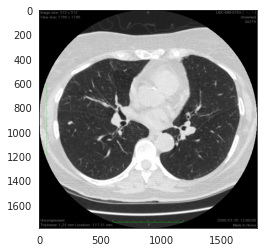

In [ ]:
# 結節ありの画像をランダムに持ってくる。持ってくる。
path = glob('drive/MyDrive/Lung_Nodule_2/Image_Processed/Nodule/*')
imgs = random.choice(path)

test_image = Image.open(imgs)
plt.imshow(test_image)

In [ ]:
transform = transforms.Compose([
           # efficietnnet-b2の解像度、trainデータのmean,stdを使用。
          transforms.Resize((260, 260)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.4305, 0.4305, 0.4305],
                                std=[0.3505, 0.3505, 0.3505])
])

test_image_tensor = transform(test_image)
print(test_image_tensor.size())

# バッチサイズの次元を追加。
test_image_tensor = test_image_tensor.unsqueeze(0)
print(test_image_tensor.size())

torch.Size([3, 260, 260])
torch.Size([1, 3, 260, 260])


In [ ]:
# CT-Lung-Nodule.ipynbで学習したモデル（EfficientNet-B2）を使用。

! pip install efficientnet_pytorch 

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=2)
# model = model.cuda()
modelname = 'efficientNet-b2'

# modelをロード
state = torch.load('drive/MyDrive/Checkpoint_CT/snapshot200.ckpt')
model.load_state_dict(state['model_state_dict'])

Loaded pretrained weights for efficientnet-b2


<All keys matched successfully>

In [ ]:
# moduleのforward関数がよばれるときに、一緒に実行したい内容を記載する。
def forward_hook(module, inputs, outputs):
  '''
  module: 登録先のネットワーク
  inputs: moduleのforward関数のインプットとなったデータ
  outputs: moduleのforward関数のアウトプット
  '''
  global feature
  # 複数のinputsに対応できるように、inputsはtupleでラップされている模様。
  # 今回はinputsは1つなので、[0]を指定。
  # hook関数の登録先であるmoduleは、今回は特徴マップを計算する層(model.feature)を想定しているので、
  # model.featuresの計算結果である、outputsをそのまま取得でき料にすればよい。
  feature = outputs[0] # feature.size() = (1 * 512 * 7 * 7)


# moduleのbackward関数がよばれる時に、一緒に実行したい内容を記載する。
def backward_hook(module, grad_inputs, grad_outputs):
  '''
  module: 登録先のネットワーク
  grad_inputs: moduleのbackward関数のインプットとなったデータ
  grad_outputs: moduleのbackward関数のアウトプット
  '''
  global feature_grad
  # hook関数の登録先であるmoduleは、forward_hookと同様にmodel.featuresを想定しているので、
  # 特徴マップの勾配が欲しいので、model.featuresの勾配結果に相当するgrad_outputsをそのまま取得する。
  feature_grad = grad_outputs[0] # feature_grad.size() = (1 * 512 * 7 * 7)


# 畳み込み層に、hook関数を登録する。
# これによってVGG19にデータが流れる際、順伝搬の畳み込み処理のところで上記の forward_hookが呼び出される。
# そしてglobal変数のfeatureに特徴マップが格納される。
# 同様に逆伝搬時にglobal変数のfeature_gradに特徴マップの勾配が格納される。
model._blocks[22].register_forward_hook(forward_hook)
model._blocks[22].register_backward_hook(backward_hook)

# このタイミングで,forward_hookが呼び出されている。
y_pred = model(test_image_tensor)
pred_index = torch.argmax(y_pred)

# y_pred[0]は、１枚の画像しか予測していないので0を指定。
# 予測結果に対して、逆誤差伝搬。
# このタイミングで,backward_hookが呼び出されている。
y_pred[0][pred_index].backward()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
# ここからは実装１と同じ。
feature_grad = feature_grad.squeeze()
# feature_vec = feature_grad.view(320, 7*7)
feature_vec = feature_grad.view(352, 9*9)


alpha = torch.mean(feature_vec, axis=1)

L = F.relu(torch.sum(feature * alpha.view(-1, 1, 1), axis=0))
L = L.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


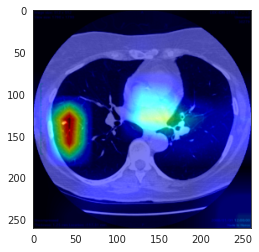

In [ ]:
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min) / L_max

L = cv2.resize(L, (260, 260))

def heat(x):
  # reshape(-1)でフラットにしている。for文で1pixelごと取得するため。
  x = x * 255
  x = x.reshape(-1)
  cm = plt.get_cmap('jet')
  x = np.array([cm(int(np.round(i)))[:3] for i in x])
  return x.reshape(260, 260, 3)

heatmap = heat(L)
image = test_image_tensor.squeeze().permute(1, 2, 0)

alpha = 0.2
grad_cam_img = image * 0.3 + (1 - alpha) * heatmap
plt.imshow(grad_cam_img)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


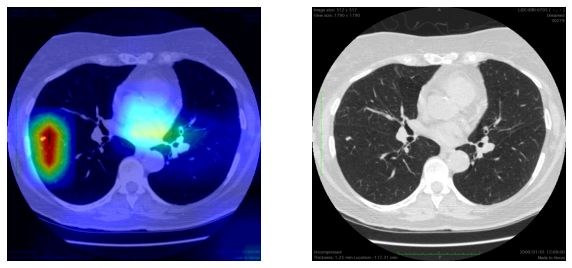

In [ ]:
# 元の画像と比較。

fig, ax = plt.subplots(1, 2, figsize=(10,20))
ax[0].imshow(grad_cam_img)
ax[0].axis('off')
ax[1].imshow(test_image)
ax[1].axis('off')

fig.savefig('drive/MyDrive/Lung_Nodule_2/grad_cam_3')